In [83]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")


In [223]:
# Temperature model parameters
T_REF = 2.730e2
ALPHA = -5.738
BETA = 2.099e2

# Open-circuit voltage curve parameters
OCV_1 = -5.863e-1
OCV_2 = 21.9
OCV_3 = 3.414
OCV_4 = 1.102e-1
OCV_5 = -1.718e-1
OCV_6 = 8.0e-3

# Simulation parameters
EPSILON = 1e-9
ZERO_CELSIUS_IN_KELVIN = 273

def calculate_soc_coeff(temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return np.exp(a / (t_ref - b) - a / (temperature - b))


def calculate_soc_with_temperature(soc, temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return soc * calculate_soc_coeff(temperature, t_ref, a, b)


def calculate_ocv(soc, a1=OCV_1, a2=OCV_2, a3=OCV_3, a4=OCV_4, a5=OCV_5, a6=OCV_6):
    return a1 * np.exp(-a2 * soc) + a3 + a4 * soc + a5 * np.exp(-a6 / (1 - soc))


# Functions for temperature
def celsius_to_kelvin(deg):
    return ZERO_CELSIUS_IN_KELVIN + deg


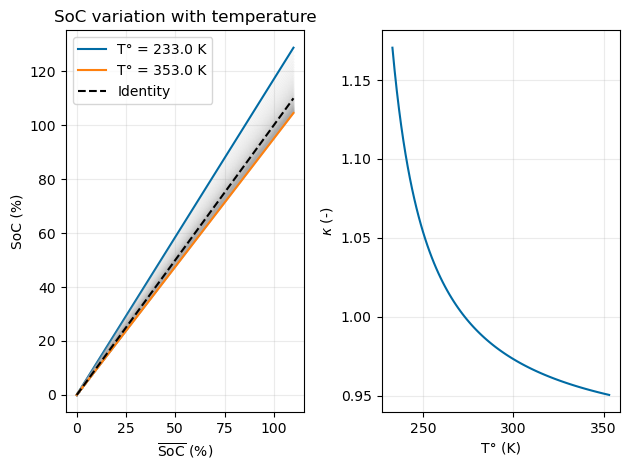

In [267]:
fig, (ax, ax_coeff) = plt.subplots(1, 2)
soc = np.linspace(0, 1.1, 100)
temperatures = np.linspace(celsius_to_kelvin(-40), celsius_to_kelvin(80), 100)

for t in temperatures:
    soc_t = calculate_soc_with_temperature(soc, t)
    if t == temperatures[0] or t == temperatures[-1]:
        ax.plot(100 * soc, 100 * soc_t, label=f"T° = {t} K")
    else:
        ax.plot(100 * soc, 100 * soc_t, alpha=0.1, color="#aaa")
ax.plot(100 * soc, 100 * soc, linestyle="--", color="#000", label="Identity")
ax.set_title("SoC variation with temperature")
ax.grid(alpha=0.25)
ax.set_xlabel(r"$\overline{\text{SoC}}$ (%)")
ax.set_ylabel("SoC (%)")
ax.legend()

ax_coeff.plot(temperatures, calculate_soc_coeff(temperatures))
ax_coeff.grid(alpha=0.25)
ax_coeff.set_xlabel("T° (K)")
ax_coeff.set_ylabel("$\\kappa$ (-)")

fig.tight_layout()

plt.show()


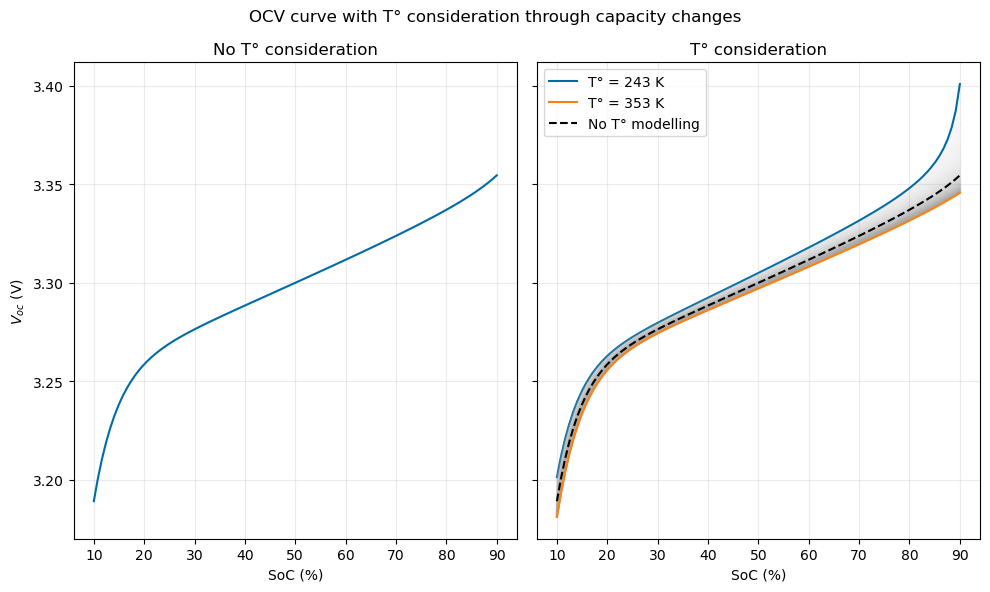

In [262]:
fig, (ax, ax_t) = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)
soc = np.linspace(0.1, 0.9, 100)
temperatures = np.linspace(celsius_to_kelvin(-30), celsius_to_kelvin(80), 100)

ax.plot(100 * soc, calculate_ocv(soc))
ax.set_title("No T° consideration")
ax.grid(alpha=0.25)
ax.set_xlabel("SoC (%)")
ax.set_ylabel("$V_{{oc}}$ (V)")

for t in temperatures:
    soc_t = calculate_soc_with_temperature(soc, t)
    ocv = calculate_ocv(soc_t)
    if t == temperatures[0] or t == temperatures[-1]:
        ax_t.plot(100 * soc, ocv, label=f"T° = {t:.0f} K")
    else:
        ax_t.plot(100 * soc, ocv, alpha=0.1, color="#aaa")
ax_t.plot(100 * soc, calculate_ocv(soc), linestyle="--", color="#000", label="No T° modelling")
ax_t.set_title("T° consideration")
ax_t.grid(alpha=0.25)
ax_t.set_xlabel("SoC (%)")
# ax_t.set_ylabel("$V_{{oc}}$ (V)")
ax_t.legend()

fig.suptitle("OCV curve with T° consideration through capacity changes")
fig.tight_layout()

plt.show()
